## 1. train textCNN model
## 2. extract the middle layer Vector as document distribution presentation
## 3. dimension-reduction 
## 4. data visualization

In [1]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM, MaxPooling1D,BatchNormalization,GRU, SpatialDropout1D
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics, regularizers
from keras.preprocessing import sequence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from bs4 import BeautifulSoup
import re
# from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
# STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


# import Job Description dataset

In [2]:
data = pd.read_csv(r'E:\dataset\Top30.csv',usecols = ['Query','Description'])
data

,Query,Description
0,Administrative Assistant,This Administrative Assistant position is resp...
1,Administrative Assistant,ADMINISTRATIVE ASSISTANT Part Time The West Or...
2,Administrative Assistant,Administrative Assistant - In Bus 26yrs Fashi...
3,Sales Representative,Are you ready for something new? Are you tired...
4,Customer Service Representative,Superior Staff Resources is currently seeking ...
...,...,...
72287,Business Analyst,ability construct complex sql statement analyz...
72288,Business Analyst,join u pursue disruptive new vision make machi...
72289,Business Analyst,duty high level independent decision making au...
72290,Business Analyst,crowdstrike leading provider next-generation e...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72292 entries, 0 to 72291
Data columns (total 2 columns):
Query          72292 non-null object
Description    72292 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


In [4]:
data.Query.value_counts()

Administrative Assistant                                      4395
Customer Service Representative                               4200
Own Your Own Franchise!                                       3701
Sales Representative                                          3556
Mobile Tool Sales / Franchise Distributor                     3275
Retail Wireless Sales Consultant                              3194
Sales / Franchise                                             3120
Project Manager                                               2845
Staff Accountant                                              2834
Retail Sales Associate                                        2769
Business Analyst                                              2420
Sales / Customer Service – Part or Full time – Summer Work    2419
Sales Representative / Account Manager /  Customer Service    2412
Senior Accountant                                             2216
Jani-King Franchise Business Opportunity                      

# data clean

In [5]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
#     text = BeautifulSoup(text, "lxml").text
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
#     pat = re.compile('<[^>]+>', re.S)
    text = cleanr.sub(' ', text)
    
    text = text.replace('\\n', ' ').replace('\\r', ' ').replace('\r', ' ').replace('\n', ' ')
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split()) # remove stopwors from text
    return text

In [6]:
data['Description'] = data['Description'].apply(clean_text)
data['Query'] = data['Query'].apply(clean_text)
data

,Query,Description
0,administrative assistant,this administrative assistant position is resp...
1,administrative assistant,administrative assistant part time the west or...
2,administrative assistant,administrative assistant in bus 26yrs fashion ...
3,sales representative,are you ready for something new are you tired ...
4,customer service representative,superior staff resources is currently seeking ...
...,...,...
72287,business analyst,ability construct comple sql statement analyze...
72288,business analyst,join u pursue disruptive new vision make machi...
72289,business analyst,duty high level independent decision making au...
72290,business analyst,crowdstrike leading provider netgeneration end...


# sample

In [7]:
data['Description'][0]

'this administrative assistant position is responsible for performing a variety of clerical and administrative support functions in the areas of communications data entry and retrieval typing filing copying and coordination of related administrative activities job requirements attention to detail ability to work in a fast paced environment invoicing proficient in word ecel and outlook other administrative responsibilities as needed qualifications high school diploma administrative assistant eperience 12 years work eperience working knowledge of all basic office machines fa copier 10key etc strong verbal and written communication skills strong work ethic'

In [8]:
import re
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')

def string_process(l):
#     temp_list = [str(i).replace('\\n', ' ').replace('\\r', ' ').replace('\r', ' ').replace('\n', ' ').strip().lower() for i in nlp(l)]
#     temp_string = ' '.join( temp_list )
#     temp_list = [str(i) for i in nlp(temp_string)] 
    temp_list = l.split()
    return temp_list

In [9]:
data['text_clean'] = data['Description'].apply( string_process )
data['len'] = data['text_clean'].apply(len)
data = data[data['len'] < 500]
data

,Query,Description,text_clean,len
0,administrative assistant,this administrative assistant position is resp...,"[this, administrative, assistant, position, is...",90
1,administrative assistant,administrative assistant part time the west or...,"[administrative, assistant, part, time, the, w...",70
2,administrative assistant,administrative assistant in bus 26yrs fashion ...,"[administrative, assistant, in, bus, 26yrs, fa...",308
3,sales representative,are you ready for something new are you tired ...,"[are, you, ready, for, something, new, are, yo...",83
4,customer service representative,superior staff resources is currently seeking ...,"[superior, staff, resources, is, currently, se...",254
...,...,...,...,...
72287,business analyst,ability construct comple sql statement analyze...,"[ability, construct, comple, sql, statement, a...",148
72288,business analyst,join u pursue disruptive new vision make machi...,"[join, u, pursue, disruptive, new, vision, mak...",265
72289,business analyst,duty high level independent decision making au...,"[duty, high, level, independent, decision, mak...",77
72290,business analyst,crowdstrike leading provider netgeneration end...,"[crowdstrike, leading, provider, netgeneration...",315


In [10]:
import numpy as np
from gensim.models import KeyedVectors

In [11]:
# load the Stanford GloVe model
filename = r'E:\dataset\word2vec\glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [12]:
word2idx = {"PAD": 0,"UNK": 1} # 初始化 `[word : token]` 字典，后期 tokenize 语料库就是用该词典。
vocab_list = [(k, model.wv[k]) for k, v in model.wv.vocab.items()]

# 存储所有 word2vec 中所有向量的数组，留意其中多一位，词向量全为 0， 用于 padding
embeddings_matrix = np.zeros((len(model.wv.vocab.items()) + 2, model.vector_size))
for i in range(len(vocab_list)):
    word = vocab_list[i][0]
    word2idx[word] = i + 2
    embeddings_matrix[i + 2] = vocab_list[i][1]
    
embeddings_matrix[1] = np.mean(embeddings_matrix, axis=0)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [13]:
max_seq_length = 500

In [14]:
def PreProcessInputData( text ):
    word_labels = []

    for sequence in text:
        len_text = len(sequence)

        ###########################################
        temp_word_labels = []
        for w in sequence:
            temp_word_labels.append( word2idx.get( str(w).lower(),1 ) )

        ###########################################
        temp_word_labels = temp_word_labels + [0] * ( max_seq_length - len_text )
        word_labels.append( temp_word_labels )

    return word_labels

In [15]:
def get_argmax( l ):
    return np.argmax(l)

In [16]:
XX = np.array( PreProcessInputData( data['text_clean'] ) )
YY = pd.get_dummies(data['Query']).values

In [17]:
data['category'] = list( YY )
data['category'] = data['category'].apply( get_argmax )
data

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Query,Description,text_clean,len,category
0,administrative assistant,this administrative assistant position is resp...,"[this, administrative, assistant, position, is...",90,2
1,administrative assistant,administrative assistant part time the west or...,"[administrative, assistant, part, time, the, w...",70,2
2,administrative assistant,administrative assistant in bus 26yrs fashion ...,"[administrative, assistant, in, bus, 26yrs, fa...",308,2
3,sales representative,are you ready for something new are you tired ...,"[are, you, ready, for, something, new, are, yo...",83,24
4,customer service representative,superior staff resources is currently seeking ...,"[superior, staff, resources, is, currently, se...",254,6
...,...,...,...,...,...
72287,business analyst,ability construct comple sql statement analyze...,"[ability, construct, comple, sql, statement, a...",148,4
72288,business analyst,join u pursue disruptive new vision make machi...,"[join, u, pursue, disruptive, new, vision, mak...",265,4
72289,business analyst,duty high level independent decision making au...,"[duty, high, level, independent, decision, mak...",77,4
72290,business analyst,crowdstrike leading provider netgeneration end...,"[crowdstrike, leading, provider, netgeneration...",315,4


In [35]:
temp_DF = data[['Query','category']].drop_duplicates()

category_dict = {}
for ind, row in temp_DF.iterrows():
    category_dict[ row['category'] ] = row['Query']

category_dict

{2: 'administrative assistant',
 24: 'sales representative',
 6: 'customer service representative',
 12: 'java developer',
 9: 'financial analyst',
 17: 'project manager',
 8: 'eecutive assistant',
 13: 'maintenance technician',
 16: 'physical therapist',
 28: 'store manager',
 27: 'staff accountant',
 10: 'inside sales representative',
 0: 'account eecutive',
 18: 'receptionist',
 26: 'senior accountant',
 4: 'business analyst',
 19: 'restaurant manager',
 1: 'account representative',
 20: 'retail sales associate',
 25: 'sales representative account manager customer service',
 23: 'sales management trainee',
 11: 'janiking franchise business opportunity',
 15: 'own your own franchise',
 5: 'cashier',
 22: 'sales franchise',
 7: 'customer service sales representative part time work',
 14: 'mobile tool sales franchise distributor',
 3: 'benefits consultant',
 21: 'sales customer service part or full time summer work'}

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split( XX,YY, test_size = 0.2, random_state = 42)
print( X_train.shape, Y_train.shape )
print( X_test.shape, Y_test.shape )

(54070, 500) (54070, 29)
(13518, 500) (13518, 29)


In [20]:
len( set( data['Query'] ) )

29

# textCNN  Embeding

In [21]:
from tensorflow import keras

feature_size = max_seq_length
dropout_rate = 0.2
num_classes  = len( set( data['Query'] ) )

inputs = keras.Input(shape=(500,), name='input_data')

embed = keras.layers.Embedding(
    len(embeddings_matrix), 
    100,
    weights=[embeddings_matrix],
    trainable=False,
    mask_zero=True,
    input_length=XX.shape[1]
    )(inputs)
# single channel. If using real embedding, you can set one static
embed = keras.layers.Reshape((500, 100, 1), name='add_channel')(embed)

pool_outputs = []
for filter_size in [3,4,5]:
    filter_shape = (filter_size, 100)
    conv = keras.layers.Conv2D(50, filter_shape, strides=(1, 1), padding='valid',
                               data_format='channels_last', activation='relu',
                               kernel_initializer='glorot_normal',
                               bias_initializer=keras.initializers.constant(0.1),
                               name='convolution_{:d}'.format(filter_size))(embed)
    max_pool_shape = (feature_size - filter_size + 1, 1)
    pool = keras.layers.MaxPool2D(pool_size=max_pool_shape,
                                  strides=(1, 1), padding='valid',
                                  data_format='channels_last',
                                  name='max_pooling_{:d}'.format(filter_size))(conv)
    pool_outputs.append(pool)

pool_outputs = keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
pool_outputs = keras.layers.Flatten(data_format='channels_last', name='flatten')(pool_outputs)
pool_outputs = keras.layers.Dropout(dropout_rate, name='dropout')(pool_outputs)

outputs = keras.layers.Dense(num_classes, activation='softmax',
                             kernel_initializer='glorot_normal',
                             bias_initializer=keras.initializers.constant(0.1),
                             name='dense')(pool_outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 100)     40000200    input_data[0][0]                 
__________________________________________________________________________________________________
add_channel (Reshape)           (None, 500, 100, 1)  0           embedding[0][0]                  
_____________________________________________________________________________________________

In [22]:
epochs = 5
batch_size = 128

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 48663 samples, validate on 5407 samples
Epoch 1/5
48663/48663 [==============================] - 188s 4ms/sample - loss: 0.7606 - acc: 0.8083 - val_loss: 0.2569 - val_acc: 0.9336
Epoch 2/5
48663/48663 [==============================] - 190s 4ms/sample - loss: 0.2515 - acc: 0.9258 - val_loss: 0.2042 - val_acc: 0.9406
Epoch 3/5
48663/48663 [==============================] - 202s 4ms/sample - loss: 0.2027 - acc: 0.9386 - val_loss: 0.1772 - val_acc: 0.9443
Epoch 4/5
48663/48663 [==============================] - 194s 4ms/sample - loss: 0.1709 - acc: 0.9470 - val_loss: 0.1633 - val_acc: 0.9495
Epoch 5/5
48663/48663 [==============================] - 203s 4ms/sample - loss: 0.1516 - acc: 0.9530 - val_loss: 0.1586 - val_acc: 0.9510


In [27]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

13518/13518 [==============================] - 14s 1ms/sample - loss: 0.1630 - acc: 0.9474
Test set
  Loss: 0.163
  Accuracy: 0.947


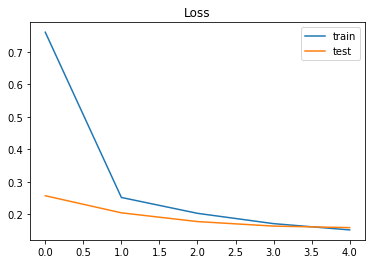

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

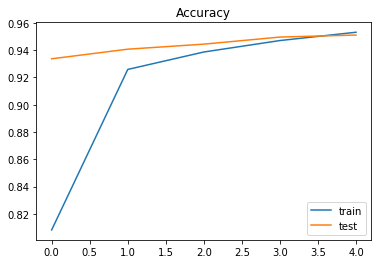

In [29]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [30]:
XX.shape

(67588, 500)

# random 500 data
# extract middle layer as document distribution presentation

In [31]:
import random
import tensorflow as tf

x_list = []
y_list = []

index = 0
while True:
    if index >= 500:
        break
    
    try:
        ranIndex = random.randint( 0,len( XX ) )

        layer_output = model.get_layer('concatenate').output
        intermediate_model = tf.keras.models.Model(inputs=model.input,outputs=layer_output)
        intermediate_prediction = intermediate_model.predict( XX[ranIndex:ranIndex+1] )

        Y_index = YY[ranIndex:ranIndex+1]

        # print( YY )
#         print( data['text_clean'][ranIndex] )
#         print()
#         print( data['Query'][ranIndex] )
#         print()

#         print( intermediate_prediction[0][0][0] )
        x_list.append( intermediate_prediction[0][0][0] )
#         y_list.append( data['Query'][ranIndex] )
        y_list.append( YY[ranIndex] )
#         print()
        index += 1

    except:
        print( 'Error' )

In [32]:
c_list = [ np.argmax(y) for y in y_list ]
c_list

[26,
 6,
 12,
 14,
 24,
 24,
 11,
 9,
 21,
 2,
 11,
 28,
 23,
 14,
 27,
 10,
 14,
 22,
 2,
 3,
 13,
 12,
 28,
 26,
 17,
 14,
 20,
 6,
 14,
 23,
 28,
 0,
 3,
 22,
 4,
 24,
 14,
 9,
 17,
 9,
 1,
 2,
 2,
 25,
 19,
 11,
 12,
 15,
 6,
 18,
 22,
 6,
 7,
 12,
 4,
 20,
 22,
 10,
 14,
 4,
 23,
 28,
 28,
 12,
 23,
 14,
 2,
 16,
 15,
 2,
 3,
 23,
 19,
 13,
 20,
 15,
 3,
 1,
 6,
 28,
 7,
 26,
 3,
 10,
 15,
 28,
 11,
 27,
 1,
 2,
 27,
 16,
 8,
 20,
 8,
 11,
 3,
 21,
 20,
 0,
 22,
 20,
 15,
 20,
 5,
 26,
 7,
 22,
 14,
 10,
 28,
 6,
 0,
 13,
 22,
 16,
 23,
 6,
 1,
 10,
 25,
 1,
 19,
 7,
 22,
 3,
 22,
 4,
 28,
 14,
 6,
 26,
 1,
 0,
 16,
 6,
 7,
 20,
 6,
 6,
 22,
 28,
 13,
 3,
 28,
 12,
 11,
 24,
 22,
 24,
 25,
 3,
 15,
 28,
 14,
 0,
 17,
 2,
 21,
 3,
 20,
 13,
 13,
 8,
 1,
 13,
 24,
 17,
 15,
 10,
 23,
 2,
 20,
 27,
 24,
 11,
 26,
 17,
 2,
 13,
 8,
 2,
 20,
 22,
 20,
 19,
 14,
 20,
 25,
 27,
 10,
 3,
 4,
 27,
 2,
 17,
 12,
 4,
 21,
 14,
 27,
 0,
 7,
 12,
 15,
 22,
 26,
 10,
 24,
 14,
 21,
 1,
 15,
 6,

# t-sne visualization

In [47]:
category_dict

{2: 'administrative assistant',
 24: 'sales representative',
 6: 'customer service representative',
 12: 'java developer',
 9: 'financial analyst',
 17: 'project manager',
 8: 'eecutive assistant',
 13: 'maintenance technician',
 16: 'physical therapist',
 28: 'store manager',
 27: 'staff accountant',
 10: 'inside sales representative',
 0: 'account eecutive',
 18: 'receptionist',
 26: 'senior accountant',
 4: 'business analyst',
 19: 'restaurant manager',
 1: 'account representative',
 20: 'retail sales associate',
 25: 'sales representative account manager customer service',
 23: 'sales management trainee',
 11: 'janiking franchise business opportunity',
 15: 'own your own franchise',
 5: 'cashier',
 22: 'sales franchise',
 7: 'customer service sales representative part time work',
 14: 'mobile tool sales franchise distributor',
 3: 'benefits consultant',
 21: 'sales customer service part or full time summer work'}

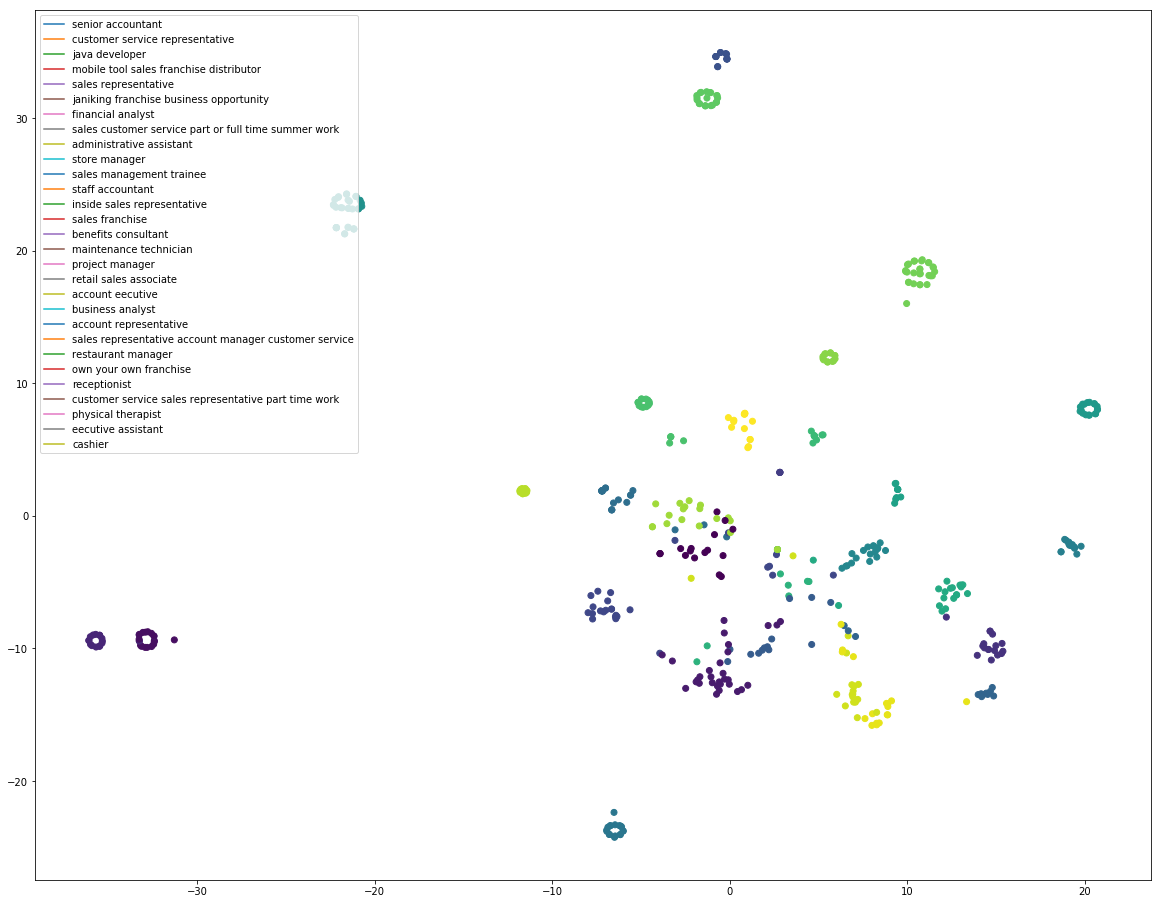

In [57]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
X_tsne = TSNE(learning_rate=100).fit_transform( x_list )

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)

ind = 0

label_list = []
for tem in X_tsne:
    if c_list[ind] not in label_list:
        ax.plot( tem[0], tem[1],label = category_dict[c_list[ind]]  )
        label_list.append( c_list[ind] )
        
    ind +=1

plt.scatter( X_tsne[:, 0], X_tsne[:, 1], c=c_list )
plt.legend()